In [34]:
from type import CrfFeatures, Abbreviation, CrfLabelSequence
import json
from sklearn.model_selection import train_test_split
from util.levenshtein_distance import edit_dist
import numpy as np
import matplotlib.pyplot as plt
from sequential_classfier import SequentialClassifier
import lightgbm as lgb

In [35]:
# 前処理した略語データを読み込む
data = list(map(Abbreviation.model_validate, json.load(open("./data/abbreviation.json", "r"))))
data_train: list[Abbreviation] = []
data_test: list[Abbreviation] = []
data_train, data_test = train_test_split(data, test_size=0.2)

In [36]:
X_train = [*map(CrfFeatures.from_abbreviation, data_train)]
y_train = list(map(CrfLabelSequence.from_abbreviation, data_train))
X_test = [*map(CrfFeatures.from_abbreviation, data_test)]
y_test = list(map(CrfLabelSequence.from_abbreviation, data_test))

In [37]:
# ラベルの番号振り
CrfFeatures.get_numbered_features(X_train)
CrfFeatures.get_numbered_features(X_test)
print("", end="")

In [38]:
model = SequentialClassifier(model=lgb.LGBMClassifier())

In [39]:
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 342
[LightGBM] [Info] Number of data points in the train set: 7556, number of used features: 161
[LightGBM] [Info] Start training from score -1.805619
[LightGBM] [Info] Start training from score -2.024344
[LightGBM] [Info] Start training from score -1.650778
[LightGBM] [Info] Start training from score -0.670122


In [40]:
y_pred = model.predict(X_test)

In [41]:
correct_n = 0
all_n = len(X_test)
score_list = np.array([0.0] * all_n)  # スコアは 編集距離 / 単語のモーラ数 で定義する

for i, (test, pred) in enumerate(zip(y_pred, y_test)):
    test = np.array(test)
    score_list[i] = (test==pred).mean()
    if (test==pred).all():
        correct_n += 1

In [42]:
correct_n / all_n

0.4645669291338583

In [43]:
score_list.mean()

0.6700242015202645

(array([ 26.,  12.,  16.,   9.,  17.,  26.,  11.,  15.,   4., 118.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

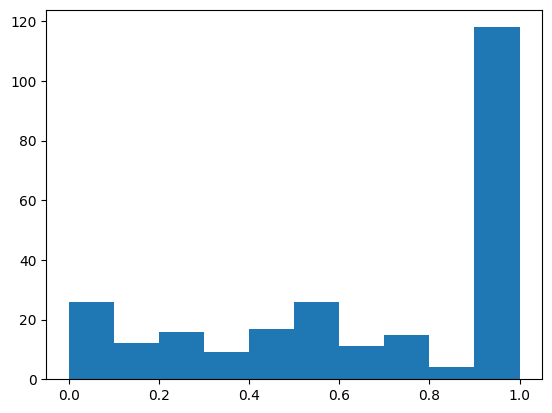

In [44]:
plt.hist(score_list, bins=10)